In [1]:
from workflow.modules import *
import resources

%load_ext autoreload
%autoreload 2

In [2]:
fp_ = 'fig4ABC.tsv'
df_ = pd.read_csv(fp_, sep='\t').merge(resources.family_index()[['PDBid', 'Type']], how='left', left_on='struct_id', right_on='PDBid')
df_['Type'] = df_['Type'].fillna(-1).map({0.0: 'apo', 1.0: 'holo', -1.0: 'AF2'}) #Type (0=Apo, 1=Holo)
#print(len(df_))

def read_struct_id_family():
    cols_ = ['SP_PRIMARY_SET', 'Family']
    return pd.concat([
        resources.family_index()[['PDBid', 'Family']].rename({'PDBid': 'struct_id'}, axis=1),
        pd.read_csv('results/lbsp_af2_check_resid.tsv', sep='\t')[cols_].rename({'SP_PRIMARY_SET': 'struct_id'}, axis=1).drop_duplicates(),
], axis=0)

df1_ = df_.query('pocket_id == 1').reset_index(drop=True).merge(read_struct_id_family(), on='struct_id')\
    .replace({'Type': {'holo': 'holo\nstructures', 'apo': 'apo\nstructures'}})
print(df1_['Type'].value_counts())
df1_.head(3).transpose()

holo\nstructures    1446
apo\nstructures     1082
AF2                  225
Name: Type, dtype: int64


,0,1,2
struct_id,4lzt,2z12,4h9b
pocket_id,1,1,1
energy,-181.741,-218.696,-177.591
n_points,455,517,389
rad_gyration,6.13232,7.42165,6.32875
energy_per_vol,-0.399431,-0.42301,-0.456532
buriedness,0.765814,0.790287,0.801389
score,43.5145,43.5071,39.4747
cl_file,results/lbsp.obabel_hxr.autosite/4l/4lzt/4lzt_...,results/lbsp.obabel_hxr.autosite/2z/2z12/2z12_...,results/lbsp.obabel_hxr.autosite/4h/4h9b/4h9b_...
cl_isfile,True,True,True


In [3]:
df_ubs = pd.read_csv('results/lbsp_af2_check_resid.tsv', sep='\t')
df_ubs['n_resid'] = df_ubs.groupby(['Family'])['ubs_ok'].transform(len)
df_ubs.head(5)

,Family,SP_PRIMARY_SET,SP_PRIMARY_LEN,Fam_number,Res,Res_number,Chain,AF_res,res_ok,ubs_ok,n_resid
0,1,P00698,1,1,ASP,119,*,ASP,True,True,33
1,1,P00698,1,1,ASP,70,*,ASP,True,True,33
2,1,P00698,1,1,ASP,105,*,ASP,True,True,33
3,1,P00698,1,1,ILE,116,*,ILE,True,True,33
4,1,P00698,1,1,ILE,106,*,ILE,True,True,33


In [4]:
df_nresid_ubs_ = df_ubs.assign(Type='Unified\nbinding\nsites')[['Family', 'Type', 'n_resid']].drop_duplicates()

In [5]:
cols_ = ['Family', 'Type', 'n_resid', 'F', 'MCC']
df_nresid_pockets_ = df1_[cols_].groupby(['Family', 'Type'])\
    .agg({'n_resid': np.median, 'F': np.median, 'MCC': np.median}).reset_index()

In [6]:
# AF2\nmean\npLDDT<=90
# AF2\nmean\npLDDT>90
pLDDT_th = 90
df_nresid_af2_split_ = pd.concat([
    df1_.query('(Type == "AF2") & (mean_pLDDT <= @pLDDT_th)').assign(Type=f'AF2\nmean\npLDDT<={pLDDT_th}'),
    df1_.query('(Type == "AF2") & (mean_pLDDT > @pLDDT_th)').assign(Type=f'AF2\nmean\npLDDT>{pLDDT_th}'),
], axis=0)[cols_]

In [7]:
df_plt_ = pd.concat([df_nresid_ubs_, df_nresid_pockets_, df_nresid_af2_split_], axis=0)
s_ = set(df_plt_.query('Type == "AF2"')['Family'])
df_plt_ = df_plt_.query('Family in @s_').reset_index(drop=True) #Match apo/holo to AF2
print(df_plt_['Type'].value_counts())
df_plt_.head(5)

holo\nstructures           225
AF2                        225
Unified\nbinding\nsites    225
apo\nstructures            225
AF2\nmean\npLDDT>90        182
AF2\nmean\npLDDT<=90        43
Name: Type, dtype: int64


,Family,Type,n_resid,F,MCC
0,1,Unified\nbinding\nsites,33.0,NaN,NaN
1,2,Unified\nbinding\nsites,42.0,NaN,NaN
2,5,Unified\nbinding\nsites,27.0,NaN,NaN
3,6,Unified\nbinding\nsites,26.0,NaN,NaN
4,9,Unified\nbinding\nsites,32.0,NaN,NaN


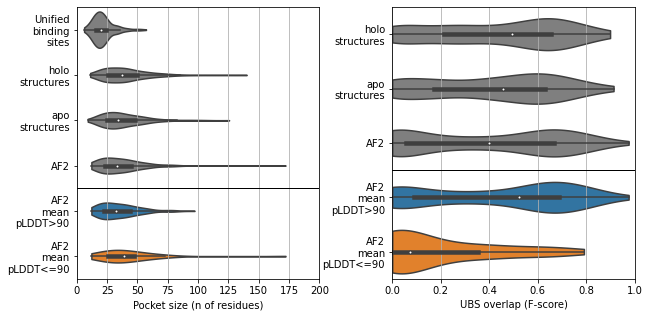

In [8]:
kwargs_ = {
    'order': ['Unified\nbinding\nsites', 'holo\nstructures', 'apo\nstructures', 'AF2', 'AF2\nmean\npLDDT>90', 'AF2\nmean\npLDDT<=90'],
    'palette': {
        'Unified\nbinding\nsites': 'tab:gray',
        'holo\nstructures': 'tab:gray',
        'apo\nstructures': 'tab:gray',
        'AF2': 'tab:gray',
        f'AF2\nmean\npLDDT>{pLDDT_th}': 'tab:blue',
        f'AF2\nmean\npLDDT<={pLDDT_th}': 'tab:orange',
    },
    'cut': 0,
}

plt.figure(figsize=(10, 5)).subplots_adjust(wspace=0.3)#, hspace=0.3)
plt.subplot(1, 2, 1)
sns.violinplot(x='n_resid', y='Type', data=df_plt_, **kwargs_)
plt.axhline(3.5, color='k', linewidth=1)
plt.gca().xaxis.grid(True)
plt.gca().set_xlim(0, 200)
plt.gca().set_xlabel('F-score')
plt.gca().set_xlabel('Pocket size (n of residues)')
plt.gca().set_ylabel('')

kwargs_['order'].remove('Unified\nbinding\nsites')
plt.subplot(1, 2, 2)
sns.violinplot(x='F', y='Type', data=df_plt_, **kwargs_)
plt.axhline(2.5, color='k', linewidth=1)
plt.gca().xaxis.grid(True)
plt.gca().set_xlim(0, 1)
plt.gca().set_xlabel('UBS overlap (F-score)')
plt.gca().set_ylabel('')
plt.savefig('fig4ABC.pdf', bbox_inches='tight', transparent=True)

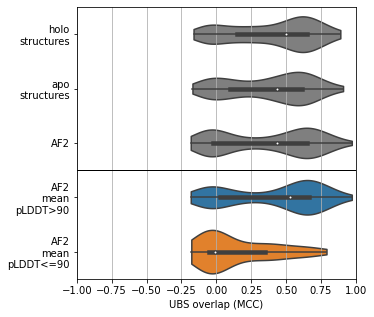

In [9]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
sns.violinplot(x='MCC', y='Type', data=df_plt_, **kwargs_)
plt.axhline(2.5, color='k', linewidth=1)
plt.gca().xaxis.grid(True)
plt.gca().set_xlim(-1, +1)
plt.gca().set_xlabel('UBS overlap (MCC)')
plt.gca().set_ylabel('')
plt.savefig('fig4ABCsuppl_MCC.pdf', bbox_inches='tight', transparent=True)